In [1]:
import numpy as np
import torch
import sys
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from torchvision import transforms
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt


In [2]:
cuda = torch.cuda.is_available()
cuda

True

In [3]:
train = MNIST('./data',train=True,download=True,transform =transforms.ToTensor())
test = MNIST('./data',train=False,download=True,transform =transforms.ToTensor())
train_data = train.data
train_data = train.transform(train_data.numpy())

In [4]:
train.data.size()

torch.Size([60000, 28, 28])

In [5]:
test.data.size()

torch.Size([10000, 28, 28])

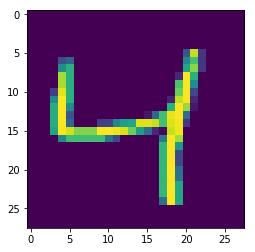

In [6]:
plt.imshow(train.data.cpu().numpy()[2])

In [7]:
class MyDataset(data.Dataset):
    def __init__(self,X,Y):
        self.X = X
        self.Y = Y
    
    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self,index):
        X = self.X[index].float().reshape(-1)
        Y = self.Y[index].long()
        return X,Y

In [8]:
sys.platform

'win32'

In [9]:
train_dataset = MyDataset(train.data,train.targets)
test_dataset = MyDataset(test.data,test.targets)


In [10]:
train_loader_args = dict(shuffle=True,batch_size=256,num_workers=0,pin_memory=True) if cuda\
else dict(shuffle=True,batch_size=64)
train_loader = data.DataLoader(train_dataset,**train_loader_args)

In [11]:
test_loader_args = dict(shuffle=True,batch_size=256,num_workers=0,pin_memory=True) if cuda\
else dict(shuffle=True,batch_size=64)
test_loader = data.DataLoader(test_dataset,**test_loader_args)

In [12]:
# Simple_MLP([784,100,50,10])

class Simple_MLP(nn.Module):
    def __init__(self,size_list):
        super(Simple_MLP,self).__init__()
        layers=[]
        self.size_list = size_list
        for i in range(len(size_list) -2):
            layers.append(nn.Linear(size_list[i],size_list[i+1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(size_list[-2],size_list[-1]))
        self.net = nn.Sequential(*layers)
        
    def forward(self,x):
        return self.net(x)

In [13]:
# define the network for training
model = Simple_MLP([784,256,200,10])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
device = torch.device("cuda" if cuda else "cpu")
print(model)

Simple_MLP(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=10, bias=True)
  )
)


In [14]:
import time
def train_epoch(model,train_loader,criterion,optimizer):
    model.train()
    model.to(device)
    running_loss=0.0
    
    start_time = time.time()
    for batch_idx, (data,target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        
        outputs = model(data)
        loss = criterion(outputs,target)
        running_loss += loss.item()
        
        loss.backward()
        optimizer.step()
    
    end_time = time.time()   
    running_loss /= len(train_loader)
    print("Train Loss: ", running_loss, ' Time: ', end_time-start_time)
    return running_loss

In [15]:
def test_epoch(model,test_loader,criterion):
    with torch.no_grad():
        model.eval()
        model.to(device)
        
        running_loss = 0.0
        total_predictions = 0.0
        correct_predictions = 0.0
        
        for batch_idx, (data,target) in enumerate(test_loader):
            data = data.to(device)
            target = target.to(device)
            outputs = model(data)
            
            _, predicted = torch.max(outputs.data,1)
            
            total_predictions += target.size(0)
            correct_predictions += (predicted==target).sum().item()
            
            loss = criterion(outputs,target).detach()
            running_loss += loss.item()
        running_loss /= len(test_loader)
        acc = (correct_predictions/total_predictions)*100.0
        print('Test Loss: ',running_loss)
        print('Test Acc: ',acc,'%')
        return running_loss,acc

In [16]:
n_epoch = 30
Train_loss = []
Test_loss = []
Test_acc = []
for i in range(n_epoch):
    train_loss = train_epoch(model,train_loader,criterion,optimizer)
    test_loss,test_acc = test_epoch(model,test_loader,criterion)
    Train_loss.append(train_loss)
    Test_loss.append(test_loss)
    Test_acc.append(test_acc)
    print('='*50)
    

Train Loss:  0.5040876720496948  Time:  2.9595494270324707
Test Loss:  0.1471781013533473
Test Acc:  95.7 %
Train Loss:  0.11526562311547868  Time:  2.1471915245056152
Test Loss:  0.1400677889585495
Test Acc:  96.0 %
Train Loss:  0.07850997833971013  Time:  2.0451464653015137
Test Loss:  0.11230794191360474
Test Acc:  96.56 %
Train Loss:  0.061568387875214535  Time:  2.231112480163574
Test Loss:  0.09336886210367083
Test Acc:  97.16 %
Train Loss:  0.04569529341731934  Time:  2.113034725189209
Test Loss:  0.09257827489636838
Test Acc:  97.39 %
Train Loss:  0.044860003591376416  Time:  2.1616485118865967
Test Loss:  0.11881576497107744
Test Acc:  96.94 %
Train Loss:  0.044802960586991715  Time:  2.1332390308380127
Test Loss:  0.11829569581896067
Test Acc:  97.23 %
Train Loss:  0.039146214703771665  Time:  2.1858181953430176
Test Loss:  0.15762823121622205
Test Acc:  96.71 %
Train Loss:  0.045993982489280244  Time:  2.168390989303589
Test Loss:  0.12415199158713222
Test Acc:  96.97 %
Trai

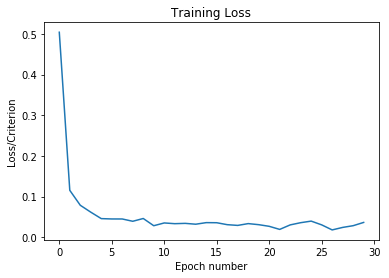

In [17]:
plt.title('Training Loss')
plt.xlabel('Epoch number')
plt.ylabel('Loss/Criterion')
plt.plot(Train_loss)

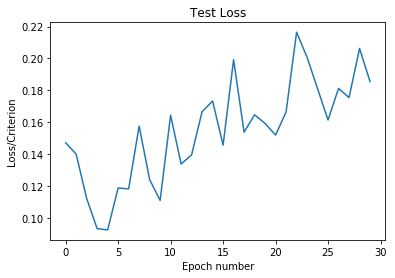

In [18]:
plt.title('Test Loss')
plt.xlabel('Epoch number')
plt.ylabel('Loss/Criterion')
plt.plot(Test_loss)

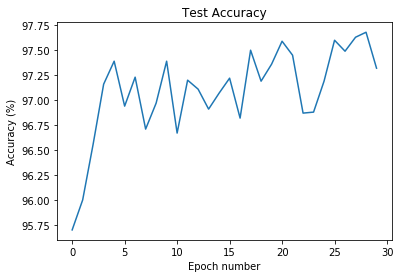

In [19]:
plt.title('Test Accuracy')
plt.xlabel('Epoch number')
plt.ylabel('Accuracy (%)')
plt.plot(Test_acc)